<a href="https://colab.research.google.com/github/sineka232/data_science/blob/main/Power_Outage_Prediction_using_Weather_%26_Infrastructure_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install SHAP for model explainability
!pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Initialize JS for SHAP plots in Colab
shap.initjs()

print("Setup Complete. Libraries Imported.")

Setup Complete. Libraries Imported.


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

def generate_grid_data(n_samples=5000):
    # 1. Temporal Data
    dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')

    # 2. Weather Features (Simulating a mix of calm days and storms)
    wind_speed = np.random.gamma(shape=2, scale=10, size=n_samples) # Skewed distribution
    temperature = np.random.normal(loc=25, scale=10, size=n_samples) # Celsius
    lightning_strikes = np.random.poisson(lam=0.5, size=n_samples) # Sparse events
    lightning_strikes = np.where(np.random.rand(n_samples) > 0.9, lightning_strikes * 10, 0) # Spikes during storms

    # 3. Infrastructure Features
    grid_load = np.random.normal(loc=500, scale=100, size=n_samples) # MW
    infrastructure_age = np.random.randint(1, 50, size=n_samples) # Years

    df = pd.DataFrame({
        'timestamp': dates,
        'wind_speed': wind_speed,
        'temperature': temperature,
        'lightning_strikes': lightning_strikes,
        'grid_load': grid_load,
        'infra_age': infrastructure_age
    })

    # 4. Target Logic: Create 'Outage' (0 or 1) based on stress factors
    # Logic: Outage is likely if Wind is high AND Infra is old, OR Lightning is extreme
    risk_score = (
        (df['wind_speed'] * 0.5) +
        (df['infra_age'] * 0.8) +
        (df['lightning_strikes'] * 2.0) +
        (df['grid_load'] * 0.05)
    )

    # Normalize risk and turn into binary target (Top 5% risk = Outage)
    threshold = np.percentile(risk_score, 95)
    df['outage_status'] = (risk_score > threshold).astype(int)

    return df

# Generate the data
df = generate_grid_data()
print(f"Data Generated: {df.shape}")
display(df.head())

Data Generated: (5000, 7)


/tmp/ipython-input-311617730.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')


,timestamp,wind_speed,temperature,lightning_strikes,grid_load,infra_age,outage_status
0,2023-01-01 00:00:00,23.936794,23.583374,0,567.690124,22,0
1,2023-01-01 01:00:00,14.944647,28.023229,0,431.993437,48,0
2,2023-01-01 02:00:00,13.822836,38.755970,0,633.264552,8,0
3,2023-01-01 03:00:00,13.823023,20.959047,0,562.620556,32,0
4,2023-01-01 04:00:00,46.497144,45.355315,0,406.323140,26,0


In [3]:
# Create rolling averages to capture trends (Time-Series aspect)
df['wind_rolling_3h'] = df['wind_speed'].rolling(window=3).mean()
df['load_rolling_3h'] = df['grid_load'].rolling(window=3).mean()

# Drop the initial rows that have NaN from rolling
df = df.dropna()

print("Feature Engineering Complete.")

Feature Engineering Complete.


In [4]:
# Select features for anomaly detection
anomaly_features = ['grid_load', 'wind_speed', 'temperature']

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit and predict (Returns -1 for anomaly, 1 for normal)
df['anomaly_label'] = iso_forest.fit_predict(df[anomaly_features])

# Convert to a score: 1 if anomaly, 0 if normal (for easier downstream processing)
df['is_anomaly'] = df['anomaly_label'].apply(lambda x: 1 if x == -1 else 0)

print("Anomaly Detection Complete. 'is_anomaly' column added.")
display(df[['timestamp', 'grid_load', 'is_anomaly']].iloc[100:105])

Anomaly Detection Complete. 'is_anomaly' column added.


,timestamp,grid_load,is_anomaly
102,2023-01-05 06:00:00,409.803186,0
103,2023-01-05 07:00:00,481.583746,0
104,2023-01-05 08:00:00,634.892751,0
105,2023-01-05 09:00:00,474.982337,0
106,2023-01-05 10:00:00,440.587639,0


In [5]:
# Define Features (X) and Target (y)
features = [
    'wind_speed', 'temperature', 'lightning_strikes',
    'infra_age', 'grid_load',
    'wind_rolling_3h', 'is_anomaly' # Our engineered features
]

X = df[features]
y = df['outage_status']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:50:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       950
           1       0.94      0.88      0.91        50

    accuracy                           0.99      1000
   macro avg       0.96      0.94      0.95      1000
weighted avg       0.99      0.99      0.99      1000



/tmp/ipython-input-598491184.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


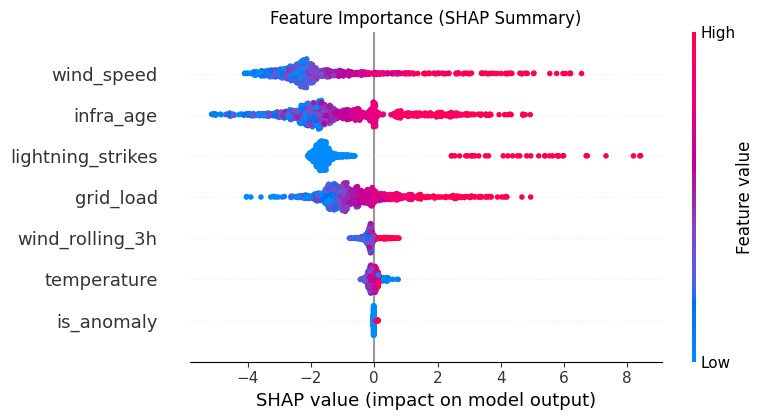

Explaining a single prediction (Red = Pushing towards Outage, Blue = Pushing away):


In [6]:
# Create SHAP Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 1. Summary Plot (Global View)
# Shows which features are most important overall
plt.title("Feature Importance (SHAP Summary)")
shap.summary_plot(shap_values, X_test)

# 2. Force Plot (Local View - Single Prediction)
# Explains ONE specific instance (e.g., the first row in test set)
# Note: In Colab, this is interactive.
print("Explaining a single prediction (Red = Pushing towards Outage, Blue = Pushing away):")
shap.plots.force(shap_values[0])

/tmp/ipython-input-598491184.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


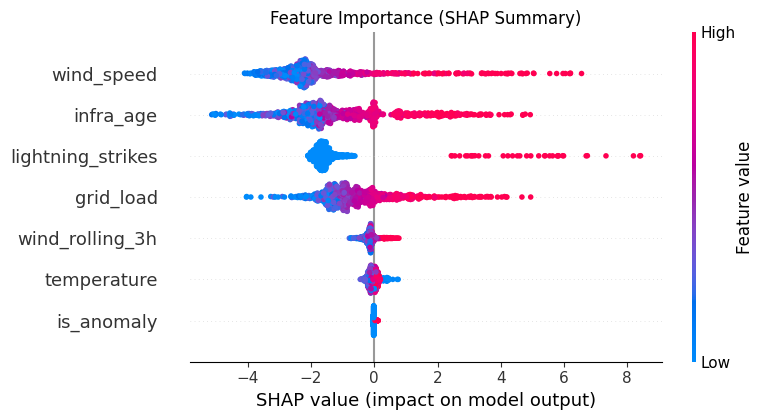

Explaining a single prediction (Red = Pushing towards Outage, Blue = Pushing away):


In [7]:
# Create SHAP Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 1. Summary Plot (Global View)
# Shows which features are most important overall
plt.title("Feature Importance (SHAP Summary)")
shap.summary_plot(shap_values, X_test)

# 2. Force Plot (Local View - Single Prediction)
# Explains ONE specific instance (e.g., the first row in test set)
# Note: In Colab, this is interactive.
print("Explaining a single prediction (Red = Pushing towards Outage, Blue = Pushing away):")
shap.plots.force(shap_values[0])

In [8]:
import collections
import time

# We use a 'deque' (double-ended queue) to efficiently store the last N hours of data
# This is necessary to calculate rolling averages in real-time.

class RealTimeGridMonitor:
    def __init__(self, model, iso_forest, window_size=3):
        self.model = model
        self.iso_forest = iso_forest
        self.window_size = window_size

        # Buffers to store history for rolling calculations
        self.wind_buffer = collections.deque(maxlen=window_size)
        self.load_buffer = collections.deque(maxlen=window_size)

        print(f"🟢 Grid Monitor Online. Waiting for stream...")

    def process_stream_data(self, raw_reading):
        """
        Ingests a single dictionary of live data, features engineers on the fly,
        and returns a prediction.
        """
        # 1. Update State (Add new reading to buffer)
        self.wind_buffer.append(raw_reading['wind_speed'])
        self.load_buffer.append(raw_reading['grid_load'])

        # We cannot predict until we have enough history for the rolling window
        if len(self.wind_buffer) < self.window_size:
            return {"status": "BUFFERING", "msg": "Gathering history..."}

        # 2. Real-Time Feature Engineering
        # Calculate the rolling mean from our buffer
        wind_rolling_3h = sum(self.wind_buffer) / len(self.wind_buffer)

        # 3. Anomaly Detection (Component A)
        # We need to reshape input because sklearn expects 2D array
        anomaly_input = pd.DataFrame([{
            'grid_load': raw_reading['grid_load'],
            'wind_speed': raw_reading['wind_speed'],
            'temperature': raw_reading['temperature']
        }])

        # Get anomaly score (0 or 1)
        is_anomaly = 1 if self.iso_forest.predict(anomaly_input)[0] == -1 else 0

        # 4. Prepare Final Vector for Prediction (Component B)
        # MUST match the exact order of training features
        input_vector = pd.DataFrame([{
            'wind_speed': raw_reading['wind_speed'],
            'temperature': raw_reading['temperature'],
            'lightning_strikes': raw_reading['lightning_strikes'],
            'infra_age': raw_reading['infra_age'],
            'grid_load': raw_reading['grid_load'],
            'wind_rolling_3h': wind_rolling_3h, # The calculated rolling feature
            'is_anomaly': is_anomaly
        }])

        # 5. Predict Probability
        prob_outage = self.model.predict_proba(input_vector)[0][1] # Probability of class 1

        # 6. Generate Alert Logic
        if prob_outage > 0.75:
            status = "CRITICAL ALERT"
        elif prob_outage > 0.4:
            status = "WARNING"
        else:
            status = "NORMAL"

        return {
            "status": status,
            "probability": f"{prob_outage:.1%}",
            "anomaly_detected": bool(is_anomaly),
            "current_wind": raw_reading['wind_speed']
        }

# --- SIMULATION LOOP ---

# Initialize the Monitor with our trained models from the previous step
monitor = RealTimeGridMonitor(model=model, iso_forest=iso_forest)

# Let's take 10 fresh data points from our dataset to simulate a live stream
# We pretend these are arriving from a Kafka stream or MQTT sensor
live_stream_simulation = df.tail(10).to_dict('records')

print("\n--- STARTING LIVE DATA STREAM ---\n")

for i, packet in enumerate(live_stream_simulation):
    # Simulate network latency
    time.sleep(0.5)

    # Process the packet
    result = monitor.process_stream_data(packet)

    # Print Dashboard Log
    if result['status'] == "BUFFERING":
        print(f"Time {i}: [Initializing System] - {result['msg']}")
    else:
        # Color code the output for readability
        if result['status'] == "CRITICAL ALERT":
            icon = "🔴"
        elif result['status'] == "WARNING":
            icon = "Rx"
        else:
            icon = "🟢"

        print(f"Time {i}: {icon} [{result['status']}] Risk: {result['probability']} | Anomaly: {result['anomaly_detected']} | Wind: {result['current_wind']:.1f} km/h")

🟢 Grid Monitor Online. Waiting for stream...

--- STARTING LIVE DATA STREAM ---

Time 0: [Initializing System] - Gathering history...
Time 1: [Initializing System] - Gathering history...
Time 2: 🟢 [NORMAL] Risk: 0.9% | Anomaly: False | Wind: 7.6 km/h
Time 3: 🟢 [NORMAL] Risk: 0.0% | Anomaly: False | Wind: 25.2 km/h
Time 4: 🟢 [NORMAL] Risk: 0.0% | Anomaly: False | Wind: 31.6 km/h
Time 5: 🟢 [NORMAL] Risk: 0.0% | Anomaly: False | Wind: 10.8 km/h
Time 6: 🔴 [CRITICAL ALERT] Risk: 98.8% | Anomaly: False | Wind: 59.7 km/h
Time 7: 🟢 [NORMAL] Risk: 0.5% | Anomaly: False | Wind: 45.6 km/h
Time 8: 🟢 [NORMAL] Risk: 0.0% | Anomaly: False | Wind: 6.3 km/h
Time 9: 🟢 [NORMAL] Risk: 0.0% | Anomaly: False | Wind: 3.0 km/h
